In [3]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.0 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# !unzip archive.zip

In [ ]:
# !pip install Pillow

In [ ]:
# pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/d9/64/7fdfb9386511cd6805451e012c537073a79a958a58795c4e602e538c388c/opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from PIL import Image
import cv2

In [ ]:
txt_files = [file_path for file_path in os.listdir("obj/") if file_path.endswith(".txt")]

In [ ]:
random.shuffle(txt_files)

In [ ]:
test_files = txt_files[-100:]
val_files = txt_files[-200: -100]
train_files = txt_files[:-200]

In [ ]:
def yolobbox2bbox(x,y,w,h):

    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2

    return x1, y1, x2, y2

In [ ]:
def box_to_IoU(x,y,w,h):

    x1, y1, x2, y2 = yolobbox2bbox(x,y,w,h)

    return min(y1, y2), min(x1, x2), max(y1, y2), max(x1, x2)

In [ ]:
def split_gen(files):
    def example_generator():

        for annotation in files:

            with open(os.path.join("obj/", annotation), "r") as fp:
                lines = fp.readlines()
                if len(lines) > 1:
                    continue

            try:
                image_path = os.path.join("obj/", annotation.replace(".txt", ".jpg"))
                assert os.path.isfile(image_path)
            except AssertionError:
                continue
            else:
                image = Image.open(image_path)
                image_numpy = np.asanyarray(image)
                if image_numpy.shape[-1] != 3:
                    continue

                metadata = lines[0].strip().split(" ")

                classification_label = int(metadata[0])
                regression_values = [float(data) for data in metadata[1:]]
                regression_values = box_to_IoU(regression_values[0], regression_values[1], regression_values[2], regression_values[3])

            yield image_numpy, (classification_label, regression_values)

    return example_generator

In [ ]:
gen = split_gen(test_files)

In [ ]:
next(gen())

(array([[[ 47,  63,  63],
         [ 44,  60,  60],
         [ 46,  62,  62],
         ...,
         [ 86,  97,  91],
         [ 87,  98,  90],
         [ 88,  99,  91]],
 
        [[ 43,  59,  59],
         [ 44,  60,  60],
         [ 44,  60,  60],
         ...,
         [ 85,  96,  88],
         [ 86,  97,  89],
         [ 87,  98,  90]],
 
        [[ 44,  60,  60],
         [ 45,  61,  61],
         [ 45,  61,  61],
         ...,
         [ 85,  96,  88],
         [ 86,  97,  89],
         [ 87,  98,  90]],
 
        ...,
 
        [[ 96, 104,  89],
         [100, 108,  93],
         [ 99, 107,  92],
         ...,
         [ 86,  86,  86],
         [ 87,  87,  85],
         [ 84,  84,  82]],
 
        [[ 94, 105,  89],
         [ 96, 107,  91],
         [ 98, 106,  91],
         ...,
         [ 85,  85,  85],
         [ 85,  85,  83],
         [ 84,  84,  82]],
 
        [[ 97, 108,  92],
         [ 99, 110,  94],
         [101, 109,  94],
         ...,
         [ 83,  83,  83],
  

In [ ]:
training_dataset = tf.data.Dataset.from_generator(
     split_gen(train_files),
     output_signature=(
         tf.TensorSpec(shape=(None, None ,3), dtype=tf.float32),
         (tf.TensorSpec(shape=(), dtype=tf.int32),
         tf.TensorSpec(shape=(4,), dtype=tf.float32))
     ),

)
validation_dataset = tf.data.Dataset.from_generator(
     split_gen(val_files),
     output_signature=(
         tf.TensorSpec(shape=(None, None ,3), dtype=tf.float32),
         (tf.TensorSpec(shape=(), dtype=tf.int32),
         tf.TensorSpec(shape=(4,), dtype=tf.float32))
     ),

)
test_dataset = tf.data.Dataset.from_generator(
     split_gen(test_files),
     output_signature=(
         tf.TensorSpec(shape=(None, None ,3), dtype=tf.float32),
         (tf.TensorSpec(shape=(), dtype=tf.int32),
         tf.TensorSpec(shape=(4,), dtype=tf.float32))
     ),

)

In [ ]:
for b in training_dataset.take(1):
    print(b)

(<tf.Tensor: shape=(521, 538, 3), dtype=float32, numpy=
array([[[163., 207., 232.],
        [160., 204., 229.],
        [159., 203., 228.],
        ...,
        [ 73.,  92.,  98.],
        [ 58.,  72.,  81.],
        [ 39.,  53.,  62.]],

       [[161., 205., 230.],
        [159., 203., 228.],
        [157., 201., 226.],
        ...,
        [ 74.,  91.,  98.],
        [ 59.,  73.,  82.],
        [ 40.,  54.,  63.]],

       [[160., 204., 229.],
        [158., 202., 227.],
        [157., 201., 226.],
        ...,
        [ 74.,  91.,  98.],
        [ 61.,  76.,  83.],
        [ 42.,  57.,  64.]],

       ...,

       [[178., 201., 195.],
        [179., 202., 196.],
        [180., 203., 197.],
        ...,
        [143.,  28.,  31.],
        [131.,  22.,  25.],
        [124.,  18.,  20.]],

       [[180., 203., 197.],
        [180., 203., 197.],
        [181., 204., 198.],
        ...,
        [148.,  23.,  27.],
        [145.,  26.,  28.],
        [137.,  22.,  25.]],

       [[182., 2

In [ ]:
training_dataset = (
    training_dataset
    .map(lambda image, labels: (tf.image.resize(image, (224, 224)), labels)))
validation_dataset = (
    validation_dataset
    .map(lambda image, labels: (tf.image.resize(image, (224, 224)), labels)))
test_dataset = (
    test_dataset
    .map(lambda image, labels: (tf.image.resize(image, (224, 224)), labels)))

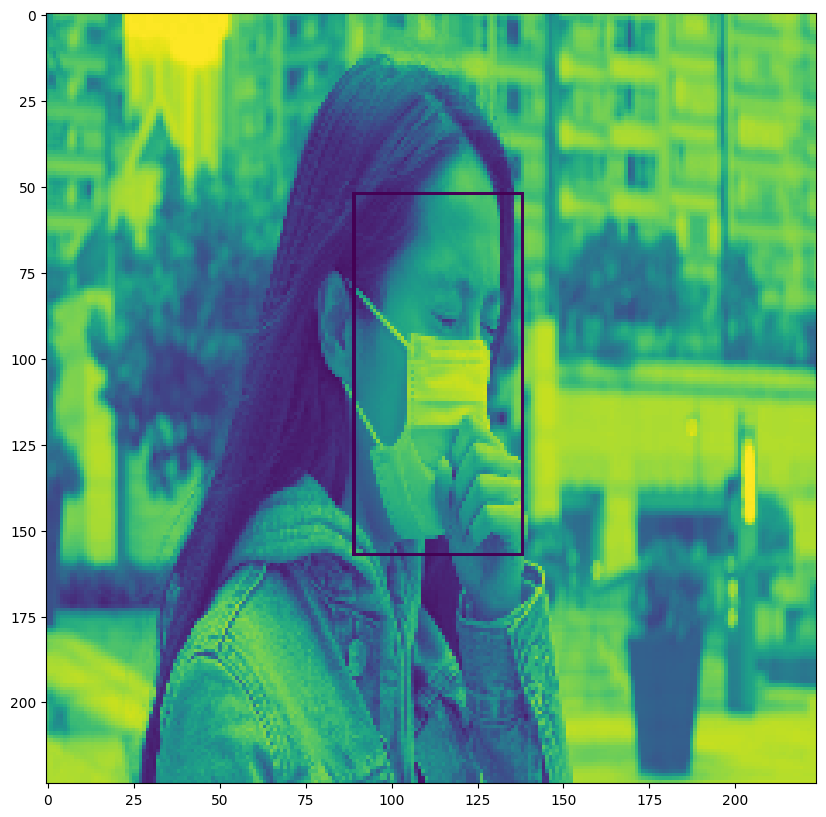

In [ ]:
plt.figure(figsize=(20, 10))
for image, (label_1, label_2) in training_dataset.skip(13).take(1):

    box = tf.cast(label_2 * 224, tf.int32).numpy()
    image_color = cv2.cvtColor(image.numpy(), cv2.COLOR_BGR2GRAY)
    cv2.rectangle(image_color, pt1=(int(box[1]), int(box[2])), pt2=(int(box[3]), int(box[0])), color=(0, 255, 0))
    plt.imshow(image_color)


In [ ]:
training_dataset = training_dataset.cache().shuffle(1_000).batch(32).prefetch(5)
validation_dataset = validation_dataset.cache().batch(32).prefetch(5)
test_dataset = test_dataset.cache().batch(32).prefetch(5)

# Modelo

In [ ]:
## Clasificador

inputs = tf.keras.layers.Input((224, 224, 3), dtype=tf.float32, name="input_image")
rescaling = tf.keras.layers.Rescaling(1. / 255)(inputs)

# Augmentation ???


# Bloques convolucionales

conv_1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", name="conv_1")(rescaling)
max_pool_1 = tf.keras.layers.MaxPool2D(name="max_pool_1")(conv_1)

conv_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", name="conv_2")(max_pool_1)
max_pool_2 = tf.keras.layers.MaxPool2D(name="max_pool_2")(conv_2)

conv_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", name="conv_3")(max_pool_2)
max_pool_3 = tf.keras.layers.MaxPool2D(name="max_pool_3")(conv_3)

conv_4 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", name="conv_4")(max_pool_3)
max_pool_4 = tf.keras.layers.MaxPool2D(name="max_pool_4")(conv_4)

conv_5 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", name="conv_5")(max_pool_4)
max_pool_5 = tf.keras.layers.MaxPool2D(name="max_pool_5")(conv_5)

conv_6 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", name="conv_6")(max_pool_5)
max_pool_6 = tf.keras.layers.MaxPool2D(name="max_pool_6")(conv_6)

x = tf.keras.layers.Flatten()(max_pool_6)
x = tf.keras.layers.Dropout(.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(.5)(x)

classification_head = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_head")(x)
regression_head = tf.keras.layers.Dense(4, name="regression_head")(x)

model = tf.keras.Model(inputs=[inputs], outputs=[classification_head, regression_head])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_image[0][0]']            
                                                                                                  
 conv_1 (Conv2D)                (None, 224, 224, 16  448         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss = {
        'classification_head' : tf.keras.losses.BinaryCrossentropy(),
        'regression_head' : tf.keras.losses.MeanSquaredError()
    },
    metrics = {
        'classification_head' : 'accuracy',
        'regression_head' : ['mse', tfa.losses.GIoULoss(mode="iou")]
    })

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    training_dataset,
    epochs=50,
    callbacks=[early_stopping],
    validation_data=validation_dataset
)

Epoch 1/50
36/36 [==============================] - 5s 31ms/step - loss: 0.7530 - classification_head_loss: 0.6566 - regression_head_loss: 0.0965 - classification_head_accuracy: 0.6172 - regression_head_mse: 0.0965 - regression_head_giou_loss: 0.8252 - val_loss: 0.6437 - val_classification_head_loss: 0.6233 - val_regression_head_loss: 0.0204 - val_classification_head_accuracy: 0.6292 - val_regression_head_mse: 0.0204 - val_regression_head_giou_loss: 0.5409
Epoch 2/50
36/36 [==============================] - 1s 20ms/step - loss: 0.6194 - classification_head_loss: 0.5523 - regression_head_loss: 0.0672 - classification_head_accuracy: 0.6670 - regression_head_mse: 0.0672 - regression_head_giou_loss: 0.7815 - val_loss: 0.4861 - val_classification_head_loss: 0.4613 - val_regression_head_loss: 0.0248 - val_classification_head_accuracy: 0.9101 - val_regression_head_mse: 0.0248 - val_regression_head_giou_loss: 0.5760
Epoch 3/50
36/36 [==============================] - 1s 20ms/step - loss: 0.439

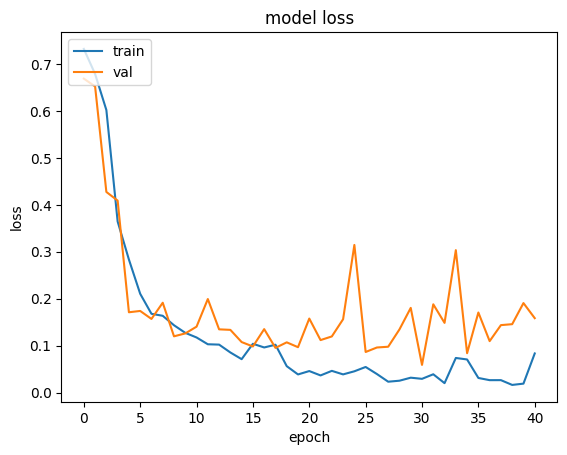

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 414ms/step


2024-05-06 11:02:23.384745: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-06 11:02:24.934022: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-06 11:02:26.416871: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. I

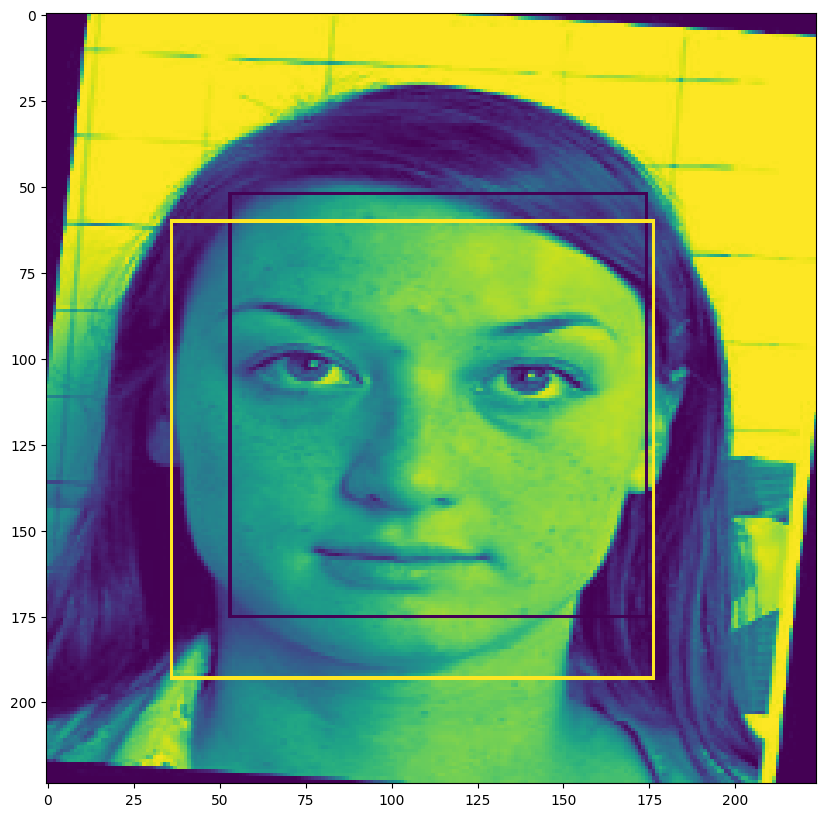

In [ ]:
plt.figure(figsize=(20, 10))
example = test_dataset.unbatch().batch(1).skip(10).take(1)
prediction = model.predict(example)
pred_box = prediction[1][0] * 224
true_box = example.get_single_element()[-1][-1].numpy()[0] * 224
image_color = cv2.cvtColor(example.get_single_element()[0].numpy()[0], cv2.COLOR_BGR2GRAY)
cv2.rectangle(image_color, pt1=(int(pred_box[1]), int(pred_box[2])), pt2=(int(pred_box[3]), int(pred_box[0])), color=(0, 255, 0))
cv2.rectangle(image_color, pt1=(int(true_box[1]), int(true_box[2])), pt2=(int(true_box[3]), int(true_box[0])), color=(255, 255, 255))
plt.imshow(image_color)